# Comparisson of GMM with full covariance with implemented models

In [1]:
import sys
sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
import utils as utl
import time
import data as d
import models as m
from tqdm import tqdm
from sklearn.mixture import GaussianMixture
tfd = tfp.distributions
tfm = tf.math
%matplotlib inline

### Load data
In this notebook i load 3 datasets (shown below) and train the following models:
- GMM with ful covariance (sklearn version)
- CP-decomposition model
- Tensor Train model

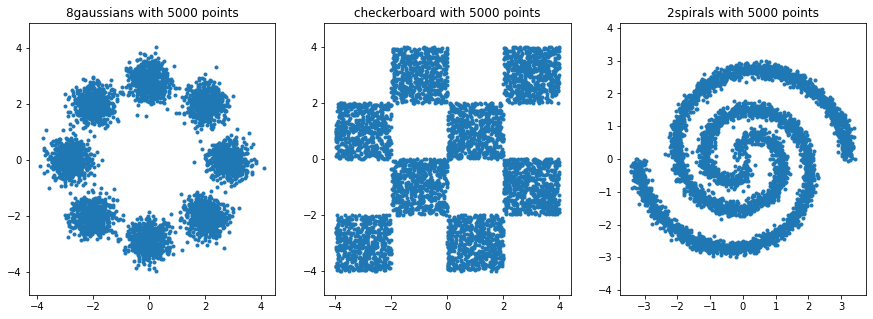

In [2]:
N = 5000
data_names = d.get_toy_names()


data1 = d.get_ffjord_data(data_names[0],batch_size=N)
data2 = d.get_ffjord_data(data_names[7],batch_size=N)
data3 = d.get_ffjord_data(data_names[6],batch_size=N)

# Inspect the data
f,ax = plt.subplots(1,3,figsize=(15,5))
ax[0].plot(data1[:, 0], data1[:, 1], '.')
ax[0].axis('equal')
ax[0].set_title(f'8gaussians with {N} points')

ax[1].plot(data2[:, 0], data2[:, 1], '.')
ax[1].axis('equal')
ax[1].set_title(f'checkerboard with {N} points')

ax[2].plot(data3[:, 0], data3[:, 1], '.')
ax[2].axis('equal')
ax[2].set_title(f'2spirals with {N} points')
plt.show()

# Split into batches
batch_size = 100
dataset1 = d.to_tf_dataset(data1, batch_size=batch_size)
dataset2 = d.to_tf_dataset(data2, batch_size=batch_size)
dataset3 = d.to_tf_dataset(data3, batch_size=batch_size)

In order to make a fair comparisson, we must evaluate the models using the same number of parameters. Below the number of parameters for each model can be seen. We set the baseline at $TensorTrain$ with $K=5$ components.

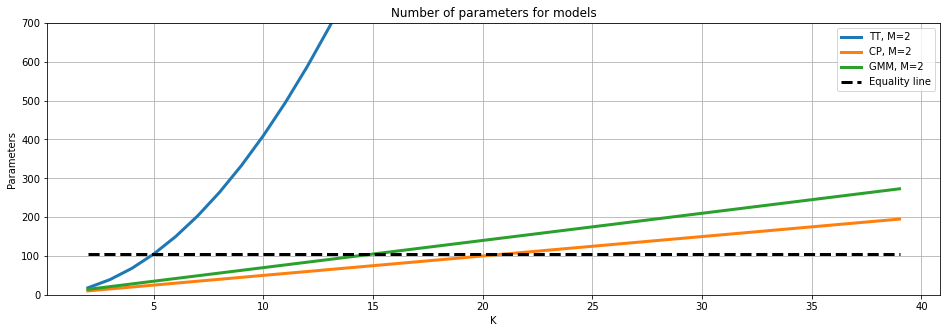

Selected number of components:
TensorTrain : 5
CP          : 21
GMM(sklean) : 15


In [3]:
K_LINE = 5
M_DIM = 2

Ks = np.arange(2,40,1)
Ms = np.arange(2,3,1)
params = np.zeros((3,len(Ms),len(Ks)))
legends = []


for i,M in enumerate(Ms):
    for j,K in enumerate(Ks):
        model_Train = m.TensorTrainGaussian(K, M)
        model_CP = m.CPGaussian(K, M)
        
        
        params[0,i,j] = model_Train.n_parameters()
        params[1,i,j] = model_CP.n_parameters()
        params[2,i,j] = K+M*K+K*M*M
    legends.append('TT, M='+str(M))
    legends.append('CP, M='+str(M))
    legends.append('GMM, M='+str(M))
    
# Make a vertical line
val = params[0,Ms==M_DIM,Ks==K_LINE][0]
line = val*np.ones(Ks.shape)
legends.append('Equality line')
    
f,ax = plt.subplots(figsize=(16,5))
for i in range(len(Ms)):
    ax.plot(Ks,params[:,i].T,linewidth=3)
ax.plot(Ks,line,'--k',linewidth=3)
ax.legend(legends)
ax.set_xlabel('K')
ax.set_ylabel('Parameters')
ax.grid('on')
ax.set_title('Number of parameters for models')
ax.set_ylim([0,700])
plt.show()

# Find indicies that achieve the same number of trainable parameters
idx_TT = np.argmax(params[0,Ms==M_DIM] >= val)
idx_CP = np.argmax(params[1,Ms==M_DIM] >= val)
idx_GMM = np.argmax(params[2,Ms==M_DIM] >= val)

# Number of components 
K_TT = Ks[idx_TT]
K_CP = Ks[idx_CP]
K_GMM = Ks[idx_GMM]

print('Selected number of components:')
print(f'TensorTrain : {K_TT}')
print(f'CP          : {K_CP}')
print(f'GMM(sklean) : {K_GMM}')

### Set training parameters

In [4]:
M = 2
EPOCHS = 400
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

### Train models 8gaussians dataset

C:\Users\rasmu\Anaconda3\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
Training TT:   0%|                                     | 0/400 [00:00<?, ?it/s]

Training time elapsed: 13 seconds
Final loss: 2.819402160644531


Training TT: 100%|███████████████████████████| 400/400 [00:18<00:00, 22.00it/s]


Training time elapsed: 18 seconds
Final loss: 2.8241607666015627


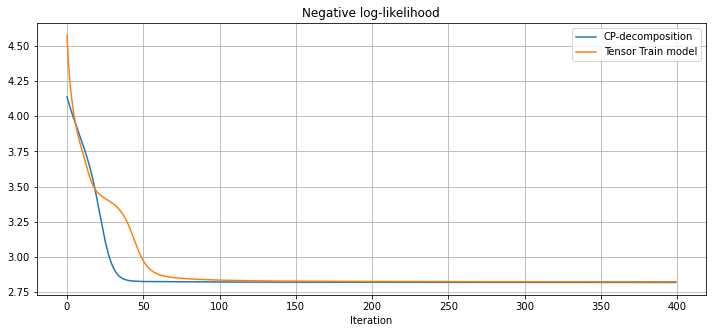

In [5]:
# Define model
model1 = GaussianMixture(n_components=K_GMM, covariance_type='full', n_init=5, 
                      tol=1e-6, reg_covar=1e-6, init_params='kmeans')


model2 = m.CPGaussian(K_CP,M)
model3 = m.TensorTrainGaussian(K_TT, M, seed = 2)

# Fit GMM with full covariance
model1.fit(data1)

# Fit CP
losses_CP = model2.fit(dataset1,EPOCHS,optimizer,'kmeans')

# Fit TT
losses_TT = model3.fit(dataset1,EPOCHS,optimizer)

# Plot learning curve
f,ax = plt.subplots(figsize=(12,5))
ax.plot(losses_CP)
ax.plot(losses_TT)
ax.set_xlabel('Iteration')
ax.set_title('Negative log-likelihood')
ax.legend(['CP-decomposition','Tensor Train model'])
ax.grid('on')
plt.show()

### Plot the result

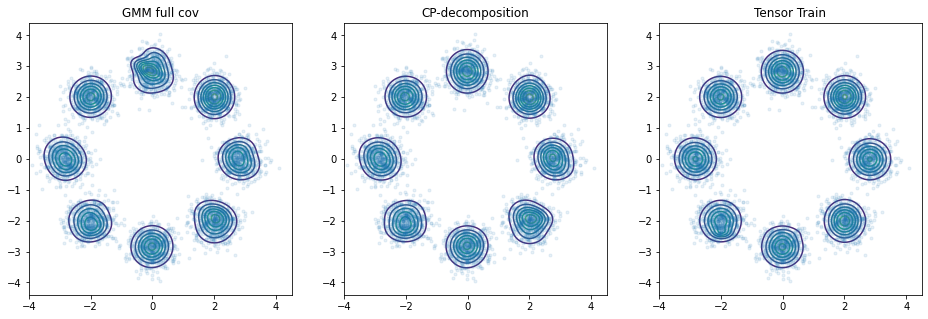

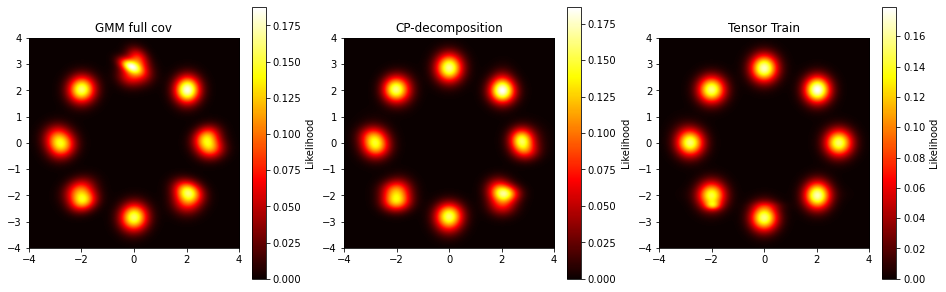

In [6]:
limit = 4
n_points = 1000
alpha = 0.1

x, _ = np.linspace(-limit, limit, n_points,retstep=True)
y, _ = np.linspace(-limit, limit, n_points,retstep=True)
x_grid, y_grid = np.meshgrid(x, y) 
X = np.array([x_grid.ravel(), y_grid.ravel()]).T

# Get the likelihood
p_log = model1.score_samples(X)
p = np.exp(p_log)

f,ax = plt.subplots(1,3,figsize=(16,5))

ax[0].plot(data1[:, 0], data1[:, 1], '.',alpha = alpha)
ax[0].contour(x_grid, y_grid, p.reshape(n_points, n_points))
ax[0].axis('equal')
ax[0].set_title('GMM full cov')
ax[0].set_ylim([-4,4])

utl.plot_contours(ax[1], data1, model2,alpha=0.1)
ax[1].set_title('CP-decomposition')
ax[1].set_ylim([-4,4])

utl.plot_contours(ax[2], data1, model3,alpha=0.1)
ax[2].set_title('Tensor Train')
ax[2].set_ylim([-4,4])

plt.show()
f.savefig('../figures/model_comparison/8gaussians_contour.png',dpi=300,facecolor='w', transparent=False)


f,ax = plt.subplots(1,3,figsize=(16,5))

im = ax[0].imshow(
    p.reshape(n_points, n_points),
    extent=(-limit, limit, -limit, limit),
    origin='lower',
    cmap='hot'
)
cbar = plt.colorbar(im, ax=ax[0])
cbar.ax.set_ylabel('Likelihood')
ax[0].set_title('GMM full cov')

utl.plot_density(ax[1], model2 ,cmap='hot')
ax[1].set_title('CP-decomposition')

utl.plot_density(ax[2], model3 ,cmap='hot')
ax[2].set_title('Tensor Train')
plt.show()
f.savefig('../figures/model_comparison/8gaussians_density.png',dpi=300,facecolor='w', transparent=False)

# Checkerboard

C:\Users\rasmu\Anaconda3\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
Training TT:   0%|                                     | 0/400 [00:00<?, ?it/s]

Training time elapsed: 13 seconds
Final loss: 3.7266079711914064


Training TT: 100%|███████████████████████████| 400/400 [00:18<00:00, 21.84it/s]


Training time elapsed: 18 seconds
Final loss: 3.7431069946289064


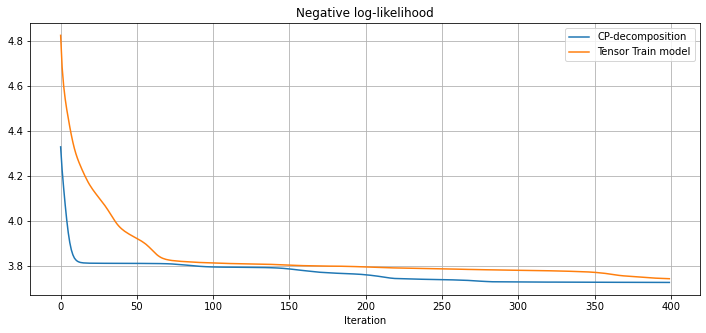

In [7]:
# Define models
model1 = GaussianMixture(n_components=K_GMM, covariance_type='full', n_init=5, 
                      tol=1e-6, reg_covar=1e-6, init_params='kmeans')
model2 = m.CPGaussian(K_CP,M)
model3 = m.TensorTrainGaussian(K_TT, M, seed = 2)

# Fit GMM with full covariance
model1.fit(data2)

# Fit CP
losses_CP = model2.fit(dataset2,EPOCHS,optimizer,'kmeans')

# Fit TT
losses_TT = model3.fit(dataset2,EPOCHS,optimizer)

# Plot learning curve
f,ax = plt.subplots(figsize=(12,5))
ax.plot(losses_CP)
ax.plot(losses_TT)
ax.set_xlabel('Iteration')
ax.set_title('Negative log-likelihood')
ax.legend(['CP-decomposition','Tensor Train model'])
ax.grid('on')
plt.show()

### Plot result

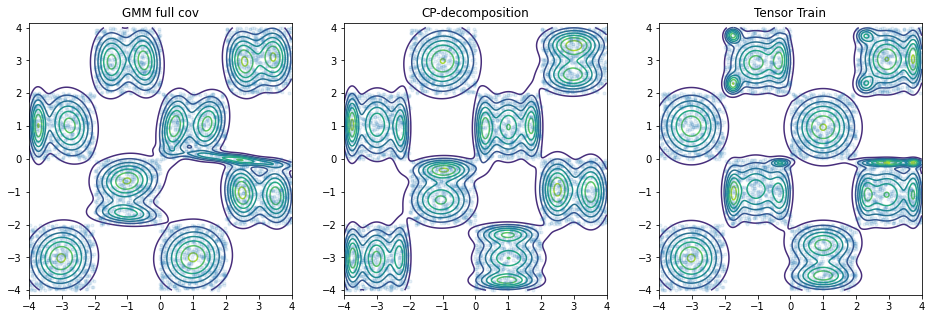

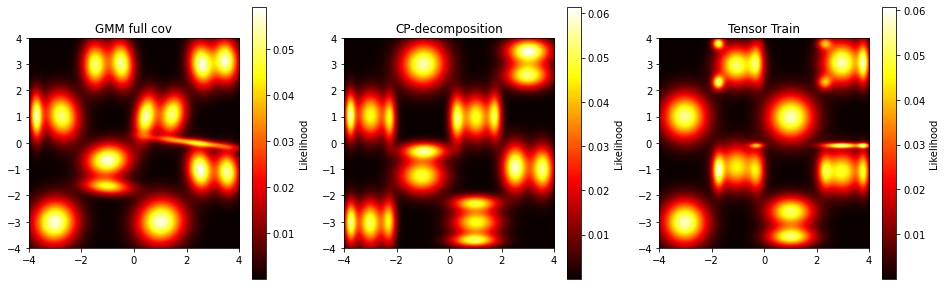

In [8]:
limit = 4
n_points = 1000
alpha = 0.1

x, _ = np.linspace(-limit, limit, n_points,retstep=True)
y, _ = np.linspace(-limit, limit, n_points,retstep=True)
x_grid, y_grid = np.meshgrid(x, y) 
X = np.array([x_grid.ravel(), y_grid.ravel()]).T

# Get the likelihood
p_log = model1.score_samples(X)
p = np.exp(p_log)

f,ax = plt.subplots(1,3,figsize=(16,5))

ax[0].plot(data2[:, 0], data2[:, 1], '.',alpha = alpha)
ax[0].contour(x_grid, y_grid, p.reshape(n_points, n_points))
ax[0].axis('equal')
ax[0].set_title('GMM full cov')
ax[0].set_ylim([-4,4])

utl.plot_contours(ax[1], data2, model2,alpha=0.1)
ax[1].set_title('CP-decomposition')
ax[1].set_ylim([-4,4])

utl.plot_contours(ax[2], data2, model3,alpha=0.1)
ax[2].set_title('Tensor Train')
ax[2].set_ylim([-4,4])

plt.show()
f.savefig('../figures/model_comparison/checkerboard_contour.png',dpi=300,facecolor='w', transparent=False)


f,ax = plt.subplots(1,3,figsize=(16,5))

im = ax[0].imshow(
    p.reshape(n_points, n_points),
    extent=(-limit, limit, -limit, limit),
    origin='lower',
    cmap='hot'
)
cbar = plt.colorbar(im, ax=ax[0])
cbar.ax.set_ylabel('Likelihood')
ax[0].set_title('GMM full cov')

utl.plot_density(ax[1], model2 ,cmap='hot')
ax[1].set_title('CP-decomposition')

utl.plot_density(ax[2], model3 ,cmap='hot')
ax[2].set_title('Tensor Train')
plt.show()
f.savefig('../figures/model_comparison/checkerboard_density.png',dpi=300,facecolor='w', transparent=False)

# 2spirals

C:\Users\rasmu\Anaconda3\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Initialization 5 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
Training TT:   0%|                                     | 0/400 [00:00<?, ?it/s]

Training time elapsed: 12 seconds
Final loss: 3.022328186035156


Training TT: 100%|███████████████████████████| 400/400 [00:19<00:00, 20.50it/s]


Training time elapsed: 19 seconds
Final loss: 3.2390182495117186


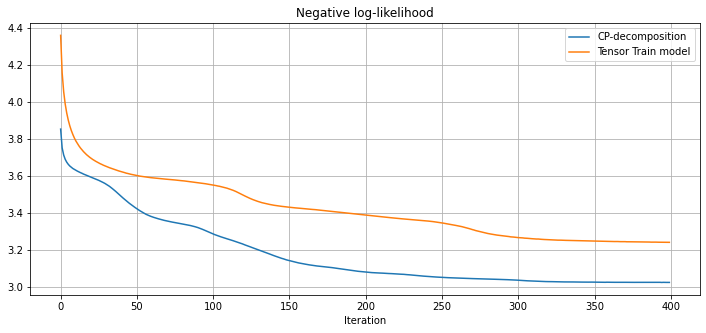

In [9]:
# Define models
model1 = GaussianMixture(n_components=K_GMM, covariance_type='full', n_init=5, 
                      tol=1e-6, reg_covar=1e-6, init_params='kmeans')
model2 = m.CPGaussian(K_CP,M)
model3 = m.TensorTrainGaussian(K_TT, M, seed = 2)

# Fit GMM with full covariance
model1.fit(data3)

# Fit CP
losses_CP = model2.fit(dataset3,EPOCHS,optimizer,'kmeans')

# Fit TT
losses_TT = model3.fit(dataset3,EPOCHS,optimizer)

# Plot learning curve
f,ax = plt.subplots(figsize=(12,5))
ax.plot(losses_CP)
ax.plot(losses_TT)
ax.set_xlabel('Iteration')
ax.set_title('Negative log-likelihood')
ax.legend(['CP-decomposition','Tensor Train model'])
ax.grid('on')
plt.show()

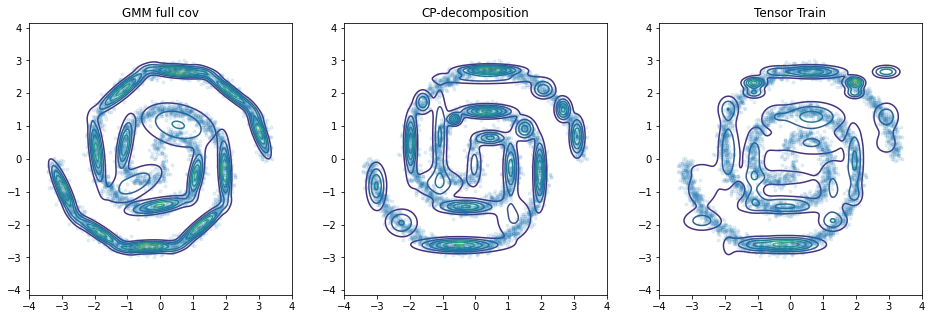

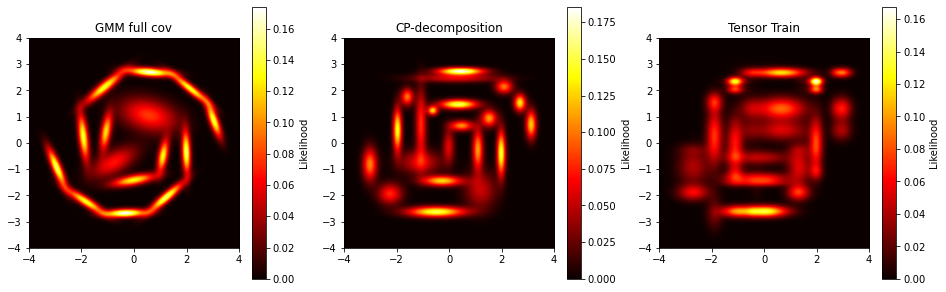

In [10]:
limit = 4
n_points = 1000
alpha = 0.1

x, _ = np.linspace(-limit, limit, n_points,retstep=True)
y, _ = np.linspace(-limit, limit, n_points,retstep=True)
x_grid, y_grid = np.meshgrid(x, y) 
X = np.array([x_grid.ravel(), y_grid.ravel()]).T

# Get the likelihood
p_log = model1.score_samples(X)
p = np.exp(p_log)

f,ax = plt.subplots(1,3,figsize=(16,5))

ax[0].plot(data3[:, 0], data3[:, 1], '.',alpha = alpha)
ax[0].contour(x_grid, y_grid, p.reshape(n_points, n_points))
ax[0].axis('equal')
ax[0].set_title('GMM full cov')
ax[0].set_ylim([-4,4])

utl.plot_contours(ax[1], data3, model2,alpha=0.1)
ax[1].set_title('CP-decomposition')
ax[1].set_ylim([-4,4])

utl.plot_contours(ax[2], data3, model3,alpha=0.1)
ax[2].set_title('Tensor Train')
ax[2].set_ylim([-4,4])

plt.show()
f.savefig('../figures/model_comparison/2spirals_contour.png',dpi=300,facecolor='w', transparent=False)


f,ax = plt.subplots(1,3,figsize=(16,5))

im = ax[0].imshow(
    p.reshape(n_points, n_points),
    extent=(-limit, limit, -limit, limit),
    origin='lower',
    cmap='hot'
)
cbar = plt.colorbar(im, ax=ax[0])
cbar.ax.set_ylabel('Likelihood')
ax[0].set_title('GMM full cov')

utl.plot_density(ax[1], model2 ,cmap='hot')
ax[1].set_title('CP-decomposition')

utl.plot_density(ax[2], model3 ,cmap='hot')
ax[2].set_title('Tensor Train')
plt.show()
f.savefig('../figures/model_comparison/2spirals_density.png',dpi=300,facecolor='w', transparent=False)

# Cross-validation
Now we try cross validation on the checkerboard data

In [11]:
# Define training parameters
epochs = 400
CV_splits = 5

print('\nCross-validating TT:\n-------------------')
train_error_TT, test_error_TT = utl.CV_1_fold(data2,K_TT,'TT',CV_splits,epochs)
print('\nCross-validating CP:\n-------------------')
train_error_CP, test_error_CP = utl.CV_1_fold(data2,K_CP,'CP',CV_splits,epochs)
print('\nCross-validating GMM:\n-------------------')
train_error_GMM, test_error_GMM = utl.CV_1_fold(data2,K_GMM,'GMM',CV_splits,epochs)


Cross-validating TT:
-------------------
Cross-validation fold 1/5
Cross-validation fold 2/5
Cross-validation fold 3/5
Cross-validation fold 4/5
Cross-validation fold 5/5

Cross-validating CP:
-------------------
Cross-validation fold 1/5
Cross-validation fold 2/5
Cross-validation fold 3/5
Cross-validation fold 4/5
Cross-validation fold 5/5

Cross-validating GMM:
-------------------
Cross-validation fold 1/5
Cross-validation fold 2/5
Cross-validation fold 3/5
Cross-validation fold 4/5
Cross-validation fold 5/5


Print results

In [12]:
print('    Training error         Test error')
print(f'TT:  {train_error_TT[0]}         {test_error_TT[0]}')
print(f'CP:  {train_error_CP[0]}         {test_error_CP[0]}')
print(f'GMM: {train_error_GMM[0]}         {test_error_GMM[0]}')

    Training error         Test error
TT:  2.118111228942871         2.1188168048858644
CP:  2.0594853210449218         2.079570007324219
GMM: 2.069121628080329         2.096042079411299
